# State-level Covid-19 Analysis for United States

This notebook utilizes [data kindly made available](https://github.com/CSSEGISandData/COVID-19) by the [Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE)](https://systems.jhu.edu/) at and used for their 
[Visual Dashboad](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6).  It provides a temporal perspective that complements their excellent geospatial presentation.   

The thing about exponentials with a measurable daily growth rate is they change so fast.  With cases increasing 25% per day,a week means a factor of 5 and a month a factor of a thousand.


* Repo for this and other notebnooks at: [https://github.com/deculler/covid19](https://github.com/deculler/covid19)
* Website for this repo: [https://deculler.github.io/covid19/](https://deculler.github.io/covid19/)

## View and run the notebooks

* [View the notebook with nbviewer](https://nbviewer.jupyter.org/github/deculler/covid19/blob/master/US-covid19-JHU.ipynb)
* [Launch it on mybinder.org](https://mybinder.org/v2/gh/deculler/covid19/master?filepath=work/US-covid19-JHU.ipynb)
* [@UCB on datahub.berkeley.edu](http://datahub.berkeley.edu/user-redirect/interact?account=deculler&repo=covid19&branch=master&path=US-covid19-JHU.ipynb)
  
## Quick links to sections

* [Cases by state](#sectionCases)
* [Deaths by state](#sectionDeaths)
* [Growth trends by state](#sectionGrowth)
* [Cases one state](#sectionOneState)
* [Projection of cases in one state](#sectionProj)
* [Projection of deaths in one state](#sectionProjDeath)

The dataset only contains confirmed cases and death, not recoveries.  The data on recoveries tends not to be very good anyways, because case tracking is so poor.  But more importantly, the level of penetration of the virus is still in such an early stage that the eventual balancing out in the SIR models is irrelevant.  With infections growing at 15% per day, if all of today's cases recovered two weeks out, it would only be 1/16th of the new cases.  We are looking at days and weeks, not months and years.

For dataframes it uses Datascience Tables (for reference see http://data8.org/datascience/tables.html) developed for introductory courses as UCB.

In [1]:
# HIDDEN
# This useful nonsense should just go at the top of your notebook.
from datascience import *
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plots
import numpy as np
import scipy
plots.style.use('fivethirtyeight')
plots.rc('lines', linewidth=2, color='r')
from ipywidgets import interact
import ipywidgets as widgets
# datascience version number of last run of this notebook
version.__version__

'0.15.0'

In [2]:
import sys
if not '.' in sys.path:
    sys.path.append(".")

# Timeseries derivative of the Tables Datafram module
from timetable import TimeTable

# Tools used throughout the notebook
from covid import *

In [3]:
def label_val(trend, x, val):
    x_val = trend.get(x, trend.time_column)
    y_val = trend.get(x, val)
    plots.text(x_val, y_val, "{:,}".format(int(y_val)))

def add_lines(trend, col, ymax, ymin, lines):
    skip = (ymax - ymin) / len(lines) 
    y = ymax
    my = np.nanmin(trend[col])
    for (date, text) in lines :
        plots.text(date, y, text)
        plots.plot([date, date], [my, y], ":")
        y = y - skip
        
def proj_trend(trend, col, start=7, end=0, dist=14):
    last_day = trend.last(trend.time_column)
    fit_start = inc_day(last_day, -start)
    end = min(end, start)
    fit_end = inc_day(last_day, -end)
    proj_prog(trend, col, dist, fit_start=fit_start, fit_end=fit_end)

In [4]:
def by_state_cases(raw_region):
    """Aggregate state level data from the raw source"""
    res = raw_region.drop(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2',
                           'Country_Region', 'Lat','Long_', 'Combined_Key']).group('Province_State', sum)
    
    for lbl in res.labels[1:] :
        res.relabel(lbl, format_day(lbl[:-4]))
    return res

def by_state_deaths(raw_region):
    """Aggregate state level data from the raw source"""
    res = raw_region.drop(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Population',
                           'Country_Region', 'Lat','Long_', 'Combined_Key']).group('Province_State', sum)
    
    for lbl in res.labels[1:] :
        res.relabel(lbl, format_day(lbl[:-4]))
    return res

## Pull Data

URL for https://github.com/nytimes/covid-19-data/blob/master/us-states.csv

In [5]:
stateCasesURL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv" 
stateDeathsURL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv" 

In [6]:
raw_states_cases = Table.read_table(stateCasesURL)
raw_states_deaths = Table.read_table(stateDeathsURL)

In [7]:
states_population = raw_states_deaths.select(['Province_State', 'Population']).group('Province_State', sum)
states_population.relabel('Population sum', 'Population')
states_population.relabel('Province_State', 'State')

State,Population
Alabama,4903185
Alaska,731545
American Samoa,55641
Arizona,7278717
Arkansas,3017804
California,39512223
Colorado,5758736
Connecticut,3565287
Delaware,973764
Diamond Princess,0


In [8]:
def population(state):
    return states_population.where('State', state)['Population'][0]

In [9]:
cases_by_state = by_state_cases(raw_states_cases)
deaths_by_state = by_state_deaths(raw_states_deaths)

cases = TimeTable.transpose(cases_by_state, 'Province_State', time_col='date', time_less = less_day, time_inc = inc_day)
deaths = TimeTable.transpose(deaths_by_state, 'Province_State', time_col='date', time_less = less_day, time_inc = inc_day)
states = cases.categories

# Construct estimate of active cases for each country
active = cases.select(cases.time_column)
for region in cases.categories:
    active[region] = cases.extract(region).trend()['active']

In [10]:
# Last day of rerported data
last_day = cases['date'][-1]
last_day

'04/26/20'

In [11]:
# Number of states/regions reported
len(states)

58

## US National picture

The following graph shows the national picture since the early cases were reported.  States began putting [shelter-in-place measures](https://www.nytimes.com/interactive/2020/us/coronavirus-stay-at-home-order.html) 
in effect March 19 (for California, March 17 for 6 of its counties).

Looking at just the overall number of cases that is when Covid-19 took off in scale.

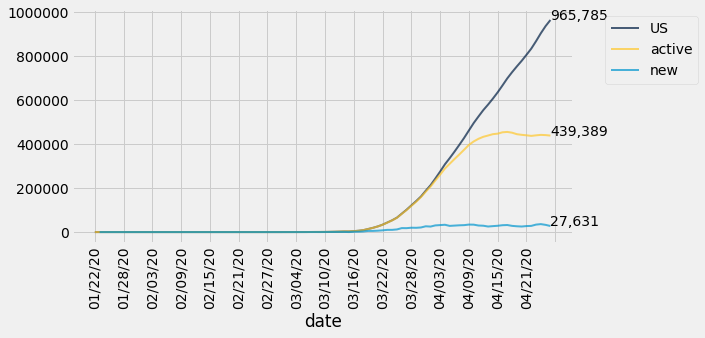

In [12]:
US_cases = cases.select(cases.time_column)
US_cases['US'] = cases.sum_cols()

US_deaths = deaths.select(cases.time_column)
US_deaths['US'] = deaths.sum_cols()

US_case_trend = US_cases.trend()
US_case_trend.extract(['US', 'active', 'new']).oplot(width=8, xlab=20)
label_val(US_case_trend, last_day, 'US')
label_val(US_case_trend, last_day, 'active')
label_val(US_case_trend, last_day, 'new')

In [13]:
# percentage of the population confirmed
US_population = sum(states_population['Population'])
"US confirmed cases: {:,} - {:.3%} of {:,} population".format(US_cases['US'][-1], US_cases['US'][-1] / US_population, US_population)

'US confirmed cases: 965,785 - 0.287% of 336,218,660 population'

In [14]:
US_deaths['US'][-1], US_deaths['US'][-1]/US_cases['US'][-1]

(54881, 0.05682527684733144)

## Pandemic Stage

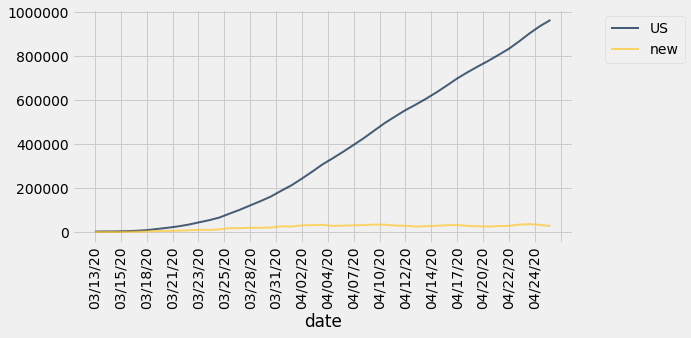

In [15]:
US_recent = US_case_trend.extract(['US', 'new']).after("03/13/20")
US_recent.oplot(width=8, xlab=20)

## Growth Rates

A much deeper picture is revealed by looking at the day-over-day growth rates across the overall course of the infection.

The daily growth rate had shot up to as muchj as 50% new cases per day for two weeks before the states finally took action.

Since that time it has been dropping steadily as the measures became broader and more consistent.  While still way to fast for the health care systems to manage, it the difference is immense.  At 17% dailey, the number of cases grows by an order of magnitude over two weeks, instead of one,

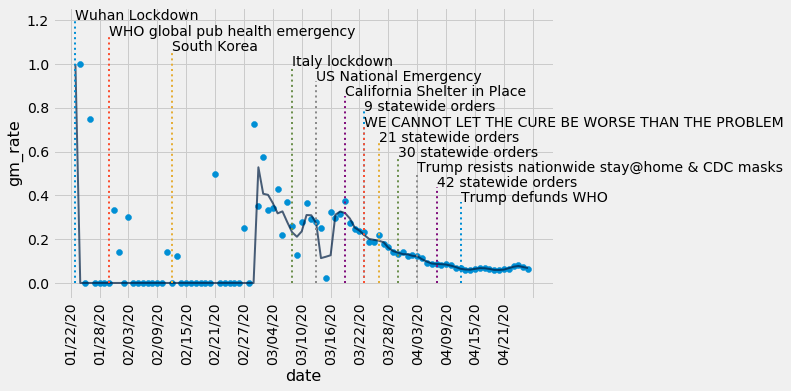

In [16]:
plot_rate_trend(US_case_trend, 'arate')
add_lines(US_case_trend, 'arate', 1.2, 0.3, [
    ("01/23/20", "Wuhan Lockdown"),
    ("01/30/20", "WHO global pub health emergency"),
    ("02/12/20", "South Korea"),
    ("03/08/20", "Italy lockdown"),
    ("03/13/20", "US National Emergency"),
    ("03/19/20", "California Shelter in Place"),
    ("03/23/20", "9 statewide orders"),
    ("03/23/20", "WE CANNOT LET THE CURE BE WORSE THAN THE PROBLEM"),
    ("03/26/20", "21 statewide orders"),
    ("03/30/20", "30 statewide orders"),
    ("04/03/20", "Trump resists nationwide stay@home & CDC masks"),
    ("04/07/20", "42 statewide orders"),
    ("04/12/20", "Trump defunds WHO")
    ])

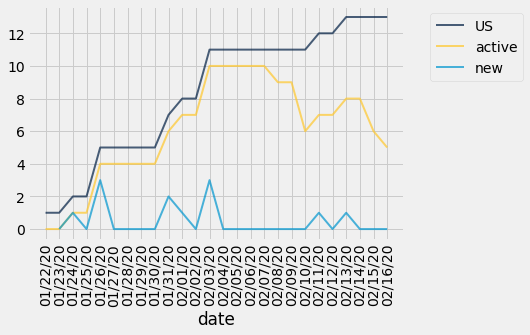

In [17]:
# Three weeks of early warning
US_case_trend.extract(['US', 'active', 'new']).before("02/16/20").oplot()

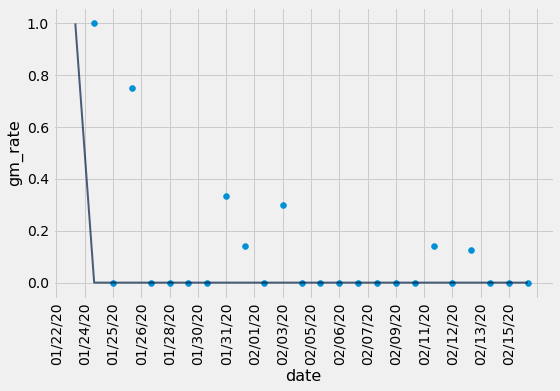

In [18]:
plot_rate_trend(US_case_trend.before("02/16/20"), 'arate')

## The lost month

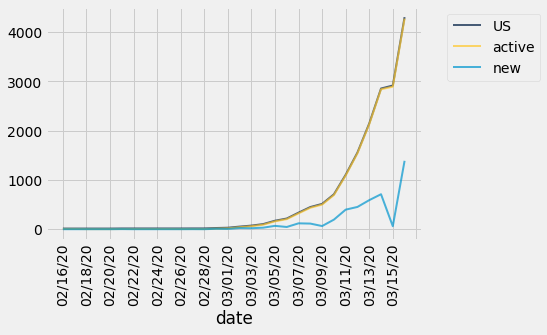

In [19]:
gap_trend = US_case_trend.between("02/16/20", "03/16/20")
gap_trend.extract(['US', 'active', 'new']).oplot(xlab=20)

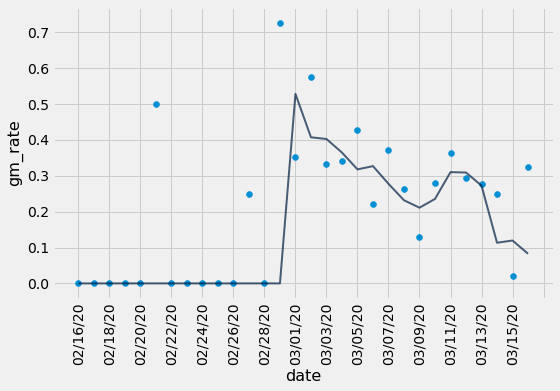

In [20]:
plot_rate_trend(gap_trend, 'arate')

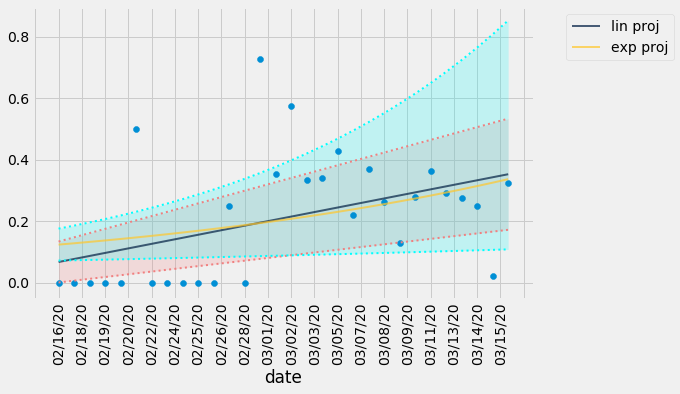

In [21]:
show_model_rate_trend(gap_trend, 'arate')

## Mitigation

Looking at the period since mitigation measures, we find a steadily enough trend that we can hope to model the future enough to attempt predictions.

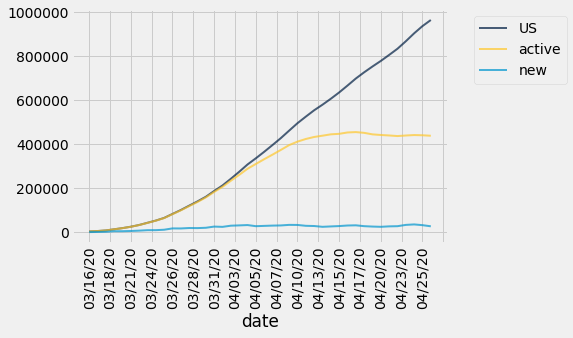

In [22]:
mgmt_trend = US_case_trend.after("03/16/20")
mgmt_trend.extract(['US', 'active', 'new']).oplot(xlab=20)

Taking just the past two week, we can get a good fit.  What we are observing here is not the properties of viral infections processes, such as SIR models as more and more of the population gains immunities, it is fundamentally the reduction in transmission rates due to human behavior.  We are still at such minute level of immunity in the population that the classic epidemiological factors hardly matter.  The challenge is what properties should we imbue to such human behavior?  Can we expect linear improvements or is the improvement a continued reduction in the oustanding rate, i.e., exponential.  Over the short term, these cannot be meaningfully differentiated.  Clearly the linear model goes negative whereas the exponential model gradually converges to zero.  The trends are so slow that we need to go out two months (an eternity) to see a notable difference.

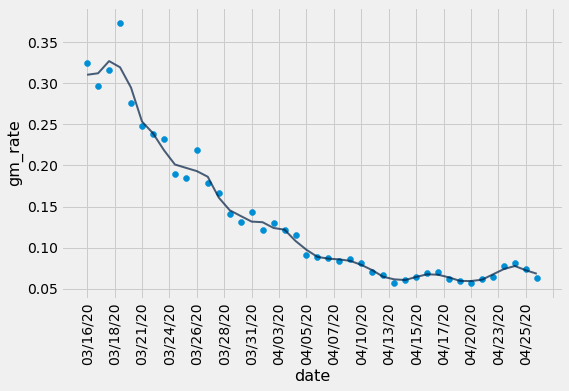

In [23]:
plot_rate_trend(mgmt_trend, 'arate')

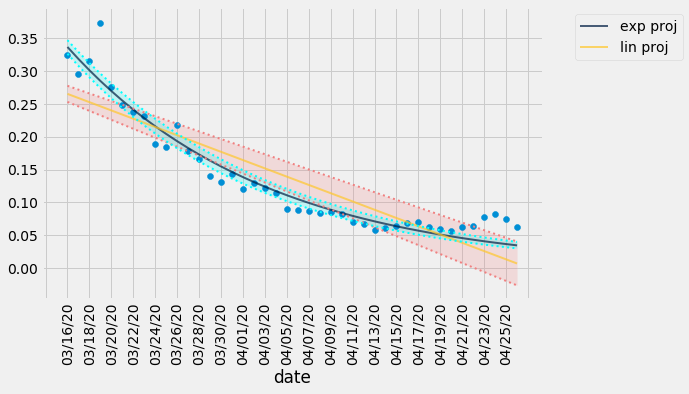

In [24]:
show_model_rate_trend(mgmt_trend, 'arate')

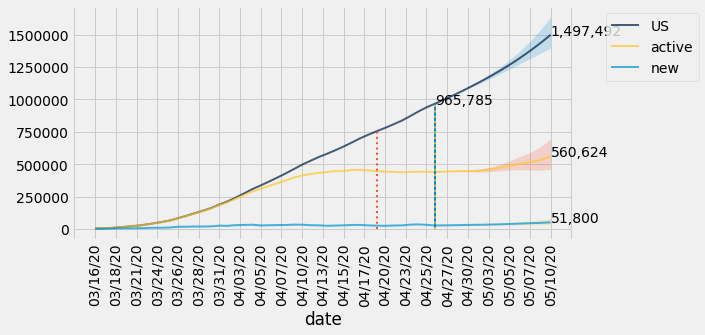

In [25]:
proj_trend(mgmt_trend, 'US', start=7, end=0, dist=14)

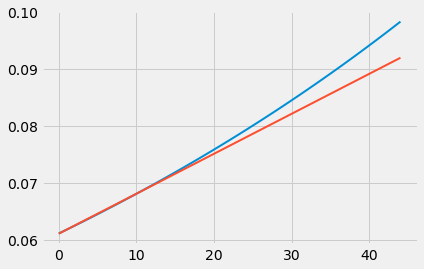

In [26]:
US_rate_proj, eparams, lparams, ecov, pcov = model_rate_trend(US_case_trend.tail(14))
def ahead(n):
    plots.plot(exp_rate(range(n), eparams[0], eparams[1]))
    plots.plot(lin_rate(range(n), lparams[0], lparams[1]))

ahead(45)

## Deaths



In [27]:
US_death_trend = US_deaths.trend(active=False)

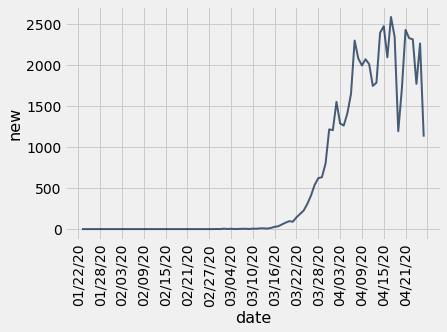

In [28]:
US_death_trend.extract('new').oplot(xlab=20)

(1, 2)

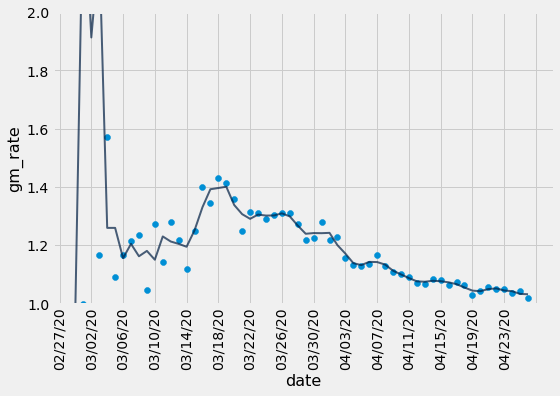

In [29]:
plot_rate_trend(US_death_trend, 'rate')
plots.ylim(1,2)

<a id=sectionCases></a>
## Cases to date by state

The following shows the national picture built up state by state.  Only the largest are shown, with the remainder
grouped into 'other'.

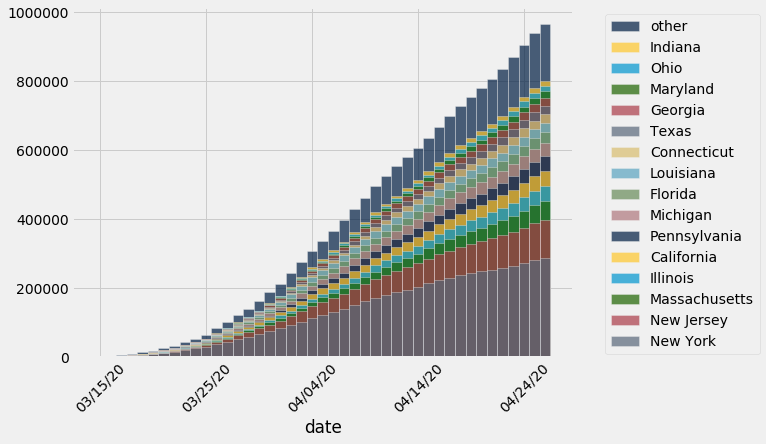

In [30]:
# Total US cases broken down by state
cases.after("03/15/20").stackbar(15, height=6, width=8)
_ = plots.xticks(rotation=45)

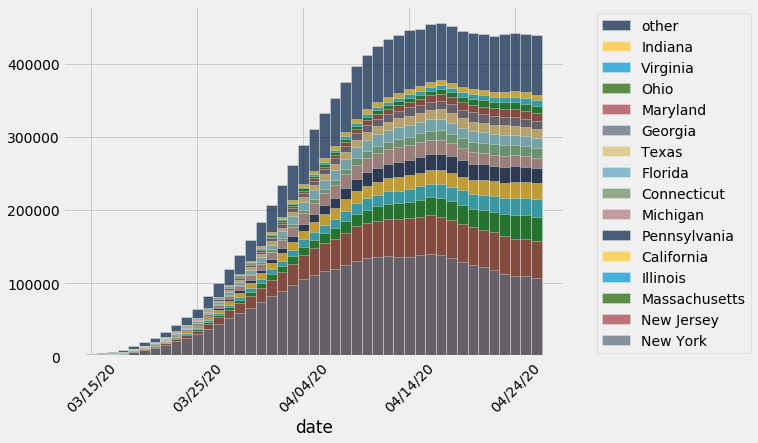

In [31]:
active.after("03/15/20").stackbar(15, height=6, width=8)
_ = plots.xticks(rotation=45)

## Early Warning

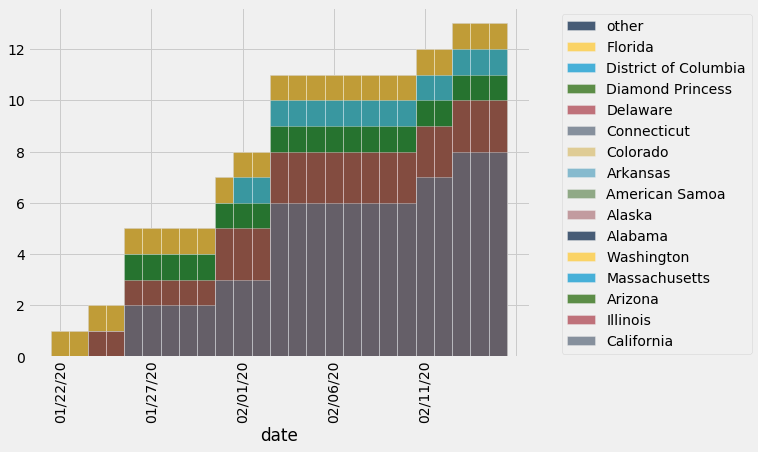

In [32]:
cases.before("02/15/20").stackbar(15, height=6, width=8)
_ = plots.xticks(rotation=90)

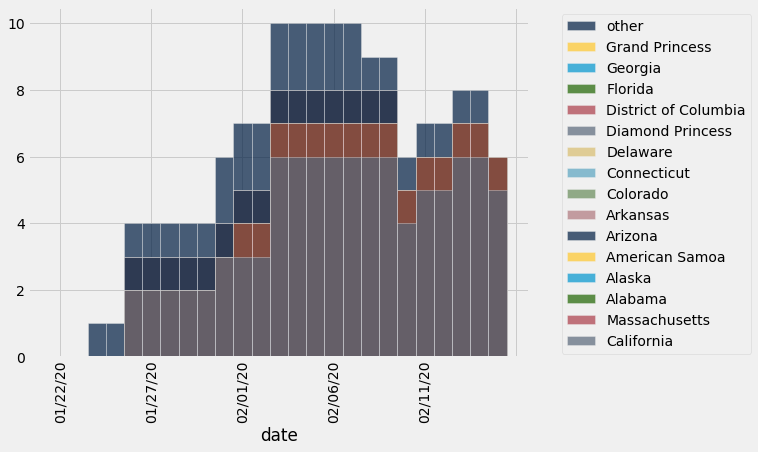

In [33]:
active.before("02/15/20").stackbar(15, height=6, width=8)
_ = plots.xticks(rotation=90)

## The Lost Month

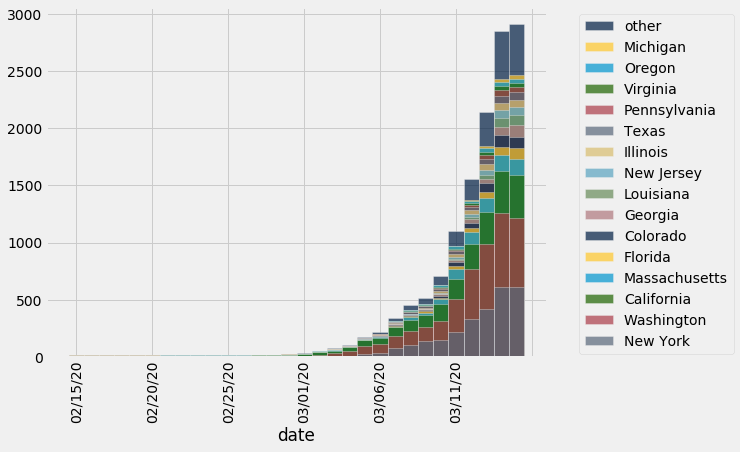

In [34]:
# What the US picture looked like during the lost month
cases.after("02/15/20").before("03/15/20").stackbar(15, height=6, width=8)
_ = plots.xticks(rotation=90)

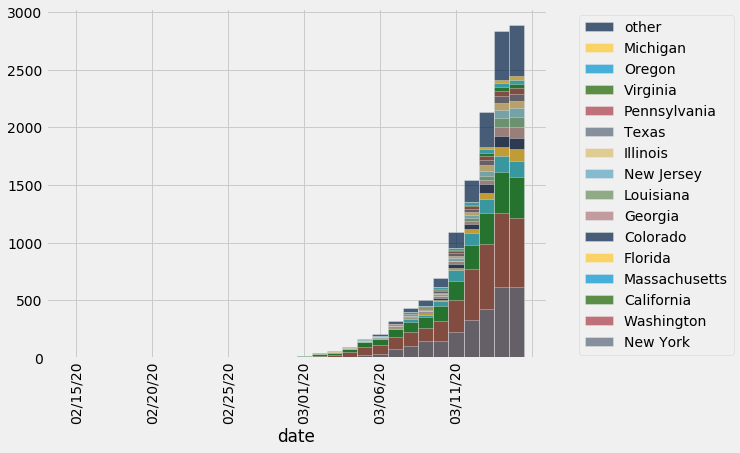

In [35]:
active.after("02/15/20").before("03/15/20").stackbar(15, height=6, width=8)
_ = plots.xticks(rotation=90)

## Cases since onset of community spread

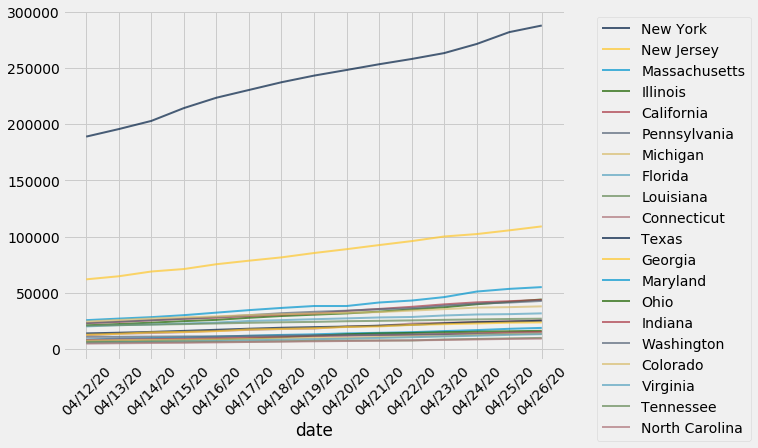

In [36]:
# Cases by state over the past two weeks
cases.top(20).tail(14).plot('date', width=8, height=6)
_ = plots.xticks(rotation=45)

In [37]:
def cases_since(ts, region, threshold=100):
    ctbl = ts.extract(region)
    since = ctbl.where(ctbl[region] >= threshold)
    ndays = since.num_rows
    vals = since[region]
    return vals
        
def show_cases_since(ts, threshold=100, limit=None, width=8, height=6):
        _, axis = plots.subplots(figsize=(width, height))
        for region in ts.categories :
            vals = cases_since(ts, region, threshold)
            if limit :
                vals = vals[:limit]
            axis.plot(vals)
            axis.text(len(vals), vals[-1], region)

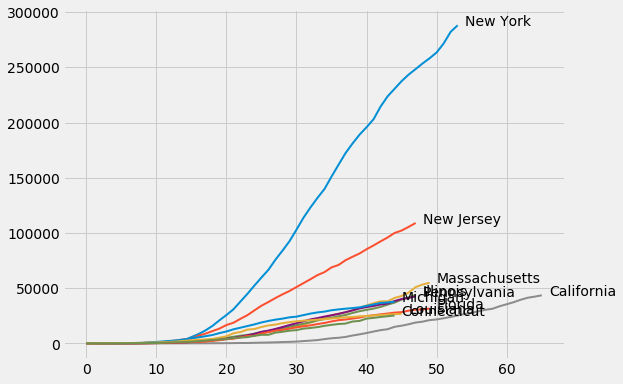

In [38]:
show_cases_since(cases.top(10), 10)

How have states handled the early community spread?  What does the month after reaching a significant number of cases look like?

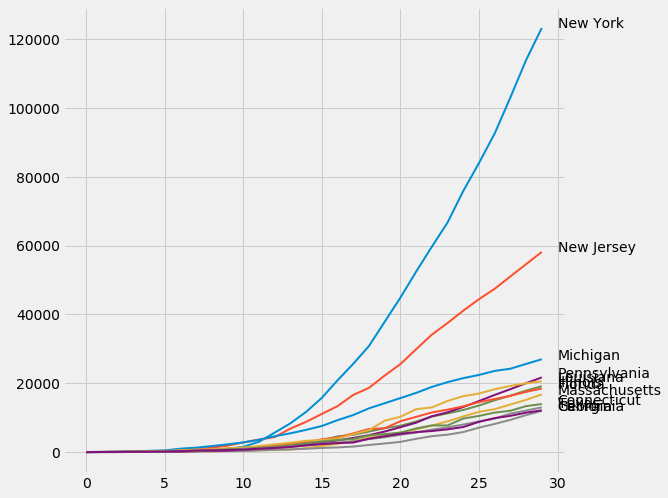

In [39]:
show_cases_since(cases.top(12), 40, 30, height=8)

In [40]:
def norm_by_population(ts):
    """Normalize region counts by population in percent"""
    normed = ts.select(ts.time_column)
    for region in ts.categories :
        if population(region) :
            normed[region] = 100*ts[region]/population(region)
    return normed

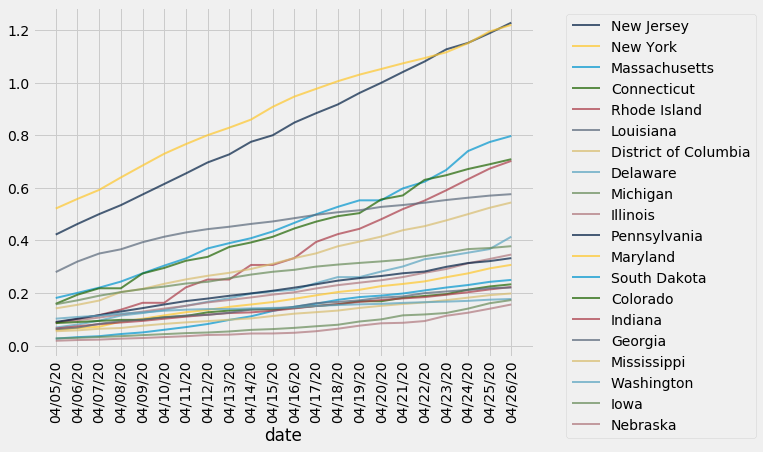

In [41]:
norm_by_population(cases).tail(21).top(20).oplot(height=6, width=8)

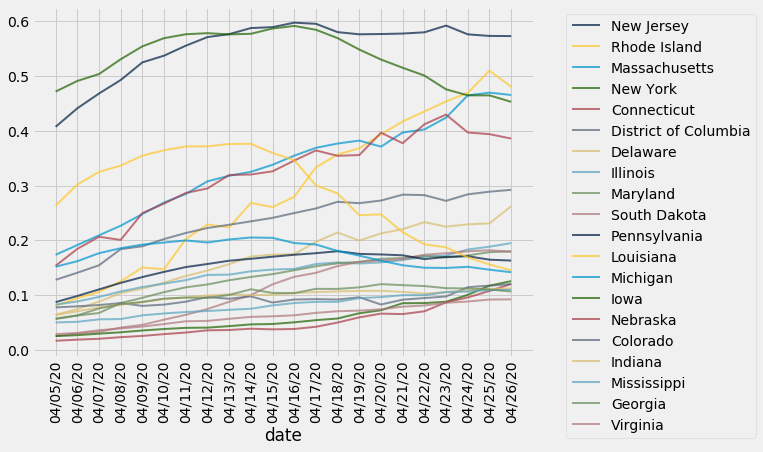

In [42]:
norm_by_population(active).tail(21).top(20).oplot(height=6, width=8)

## <a id=sectionDeaths>Deaths to date by state</a>

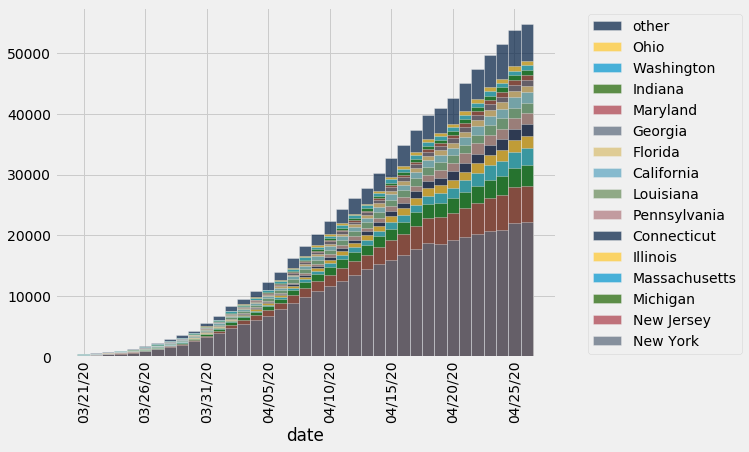

In [43]:
deaths.after("03/21/20").stackbar(15, height=6, width=8)
_ = plots.xticks(rotation=90)

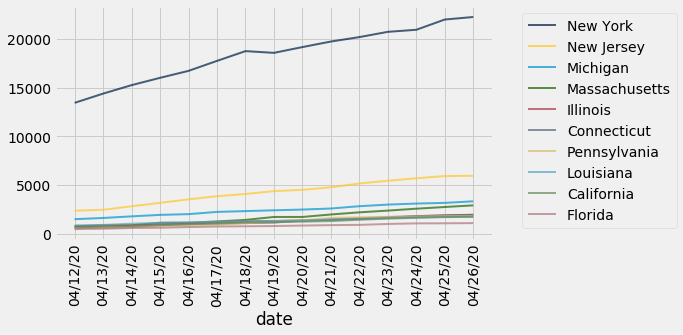

In [44]:
deaths.top(10).tail(14).oplot(width=7)

In [45]:
deaths.order_cols().trend().tail(7)

date,New York,new New York,%new New York,rate New York,active New York,arate New York,New Jersey,new New Jersey,%new New Jersey,rate New Jersey,active New Jersey,arate New Jersey,Michigan,new Michigan,%new Michigan,rate Michigan,active Michigan,arate Michigan,Massachusetts,new Massachusetts,%new Massachusetts,rate Massachusetts,active Massachusetts,arate Massachusetts,Illinois,new Illinois,%new Illinois,rate Illinois,active Illinois,arate Illinois,Connecticut,new Connecticut,%new Connecticut,rate Connecticut,active Connecticut,arate Connecticut,Pennsylvania,new Pennsylvania,%new Pennsylvania,rate Pennsylvania,active Pennsylvania,arate Pennsylvania,Louisiana,new Louisiana,%new Louisiana,rate Louisiana,active Louisiana,arate Louisiana,California,new California,%new California,rate California,active California,arate California,Florida,new Florida,%new Florida,rate Florida,active Florida,arate Florida,Georgia,new Georgia,%new Georgia,rate Georgia,active Georgia,arate Georgia,Maryland,new Maryland,%new Maryland,rate Maryland,active Maryland,arate Maryland,Indiana,new Indiana,%new Indiana,rate Indiana,active Indiana,arate Indiana,Washington,new Washington,%new Washington,rate Washington,active Washington,arate Washington,Ohio,new Ohio,%new Ohio,rate Ohio,active Ohio,arate Ohio,Colorado,new Colorado,%new Colorado,rate Colorado,active Colorado,arate Colorado,Texas,new Texas,%new Texas,rate Texas,active Texas,arate Texas,Virginia,new Virginia,%new Virginia,rate Virginia,active Virginia,arate Virginia,North Carolina,new North Carolina,%new North Carolina,rate North Carolina,active North Carolina,arate North Carolina,Missouri,new Missouri,%new Missouri,rate Missouri,active Missouri,arate Missouri,Arizona,new Arizona,%new Arizona,rate Arizona,active Arizona,arate Arizona,Minnesota,new Minnesota,%new Minnesota,rate Minnesota,active Minnesota,arate Minnesota,Wisconsin,new Wisconsin,%new Wisconsin,rate Wisconsin,active Wisconsin,arate Wisconsin,Mississippi,new Mississippi,%new Mississippi,rate Mississippi,active Mississippi,arate Mississippi,Rhode Island,new Rhode Island,%new Rhode Island,rate Rhode Island,active Rhode Island,arate Rhode Island,Alabama,new Alabama,%new Alabama,rate Alabama,active Alabama,arate Alabama,Kentucky,new Kentucky,%new Kentucky,rate Kentucky,active Kentucky,arate Kentucky,Nevada,new Nevada,%new Nevada,rate Nevada,active Nevada,arate Nevada,Oklahoma,new Oklahoma,%new Oklahoma,rate Oklahoma,active Oklahoma,arate Oklahoma,Tennessee,new Tennessee,%new Tennessee,rate Tennessee,active Tennessee,arate Tennessee,District of Columbia,new District of Columbia,%new District of Columbia,rate District of Columbia,active District of Columbia,arate District of Columbia,South Carolina,new South Carolina,%new South Carolina,rate South Carolina,active South Carolina,arate South Carolina,Kansas,new Kansas,%new Kansas,rate Kansas,active Kansas,arate Kansas,Delaware,new Delaware,%new Delaware,rate Delaware,active Delaware,arate Delaware,Iowa,new Iowa,%new Iowa,rate Iowa,active Iowa,arate Iowa,New Mexico,new New Mexico,%new New Mexico,rate New Mexico,active New Mexico,arate New Mexico,Oregon,new Oregon,%new Oregon,rate Oregon,active Oregon,arate Oregon,Puerto Rico,new Puerto Rico,%new Puerto Rico,rate Puerto Rico,active Puerto Rico,arate Puerto Rico,New Hampshire,new New Hampshire,%new New Hampshire,rate New Hampshire,active New Hampshire,arate New Hampshire,Idaho,new Idaho,%new Idaho,rate Idaho,active Idaho,arate Idaho,Nebraska,new Nebraska,%new Nebraska,rate Nebraska,active Nebraska,arate Nebraska,Arkansas,new Arkansas,%new Arkansas,rate Arkansas,active Arkansas,arate Arkansas,Maine,new Maine,%new Maine,rate Maine,active Maine,arate Maine,Vermont,new Vermont,%new Vermont,rate Vermont,active Vermont,arate Vermont,Utah,new Utah,%new Utah,rate Utah,active Utah,arate Utah,West Virginia,new West Virginia,%new West Virginia,rate West Virginia,active West Virginia,arate West Virginia,North Dakota,new North Dakota,%new North Dakota,rate North 

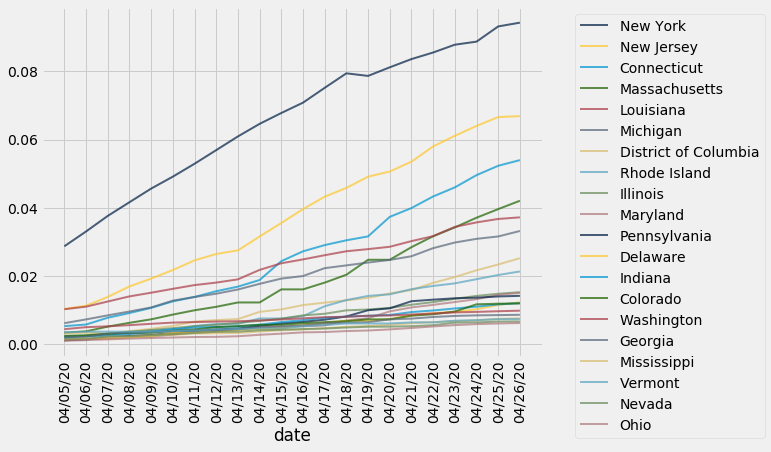

In [46]:
norm_by_population(deaths).tail(21).top(20).oplot(height=6, width=8)

## Changes in case rates

In [47]:
get_rates(cases).tail(7)

date,Alabama,Alaska,American Samoa,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Diamond Princess,District of Columbia,Florida,Georgia,Grand Princess,Guam,Hawaii,Idaho,Illinois,Indiana,Iowa,Kansas,Kentucky,Louisiana,Maine,Maryland,Massachusetts,Michigan,Minnesota,Mississippi,Missouri,Montana,Nebraska,Nevada,New Hampshire,New Jersey,New Mexico,New York,North Carolina,North Dakota,Northern Mariana Islands,Ohio,Oklahoma,Oregon,Pennsylvania,Puerto Rico,Rhode Island,South Carolina,South Dakota,Tennessee,Texas,Utah,Vermont,Virgin Islands,Virginia,Washington,West Virginia,Wisconsin,Wyoming
04/19/20,0.0537569,0.0337838,nan,0.0717227,0.0356455,0.0505539,0.123241,0.0324767,0,nan,0.0671602,0.055627,0.052055,nan,0,0.0262009,0.0201238,0.05985,0.078534,0.183924,0.069594,0.123837,0.0304409,0.0486618,0.0535898,0.064728,0.0368045,0.0985915,0.106421,0.0477716,0.0416667,0.195143,0.0513595,0.0564706,0.0758348,0.0351008,0.0456044,0.0663426,0.142857,0,0.175506,0.0725462,0.0652819,0.0556595,0.124836,0.0551282,0.052439,0.0653549,0.128335,0.0438037,0.0926264,0.0284091,0,0.0797066,0.0426971,0.172697,0.0634715,0.031746
04/20/20,0.0576343,0.0147059,nan,0.0482315,0.169014,0.120899,0,0.131047,0.0999035,nan,0.0696104,0.0506493,0.0866771,nan,0,0.0187793,0.00673401,0.0570751,0.065549,0.112227,0.110254,0.0429594,0.0516807,0.0197531,0.0831429,0,0.0353765,0.0742671,0.0828114,0.0414903,0,0.135514,0.0516456,0.0690073,0.0667942,0.0935412,0.0401897,0.0692416,0.1,0,0.148378,0.0792426,0.0528684,0.0453303,0.0501931,0.0921305,0.028786,0.0346021,0.0466019,0.0391485,0.08933,0.00986842,0,0.0705512,0.031709,0.0207612,0.0702157,0.0333333
04/21/20,0.0707281,0.057554,nan,0.0672389,0.0152466,0.0914841,0.140454,0.0405084,0.0865922,nan,0.0854573,0.0556892,0.0377178,nan,0,0.0100503,0.100787,0.0743376,0.0572749,0.17885,0.0882129,0.0684749,0.0331431,0.033419,0.0501577,0.1141,0.0431827,0.0613536,0.0685024,0.0528529,0.0289855,0.0291798,0.0539315,0.0554839,0.0714467,0,0.0419296,0.0572867,0.0405728,0,0.0869284,0.0859269,0.0502137,0.0603472,0.0585987,0.0928022,-0.00317173,0.0477164,0.0434298,0.0656771,0.0518839,0.00727273,0,0.0947867,0.0681206,0.0106572,0.0579044,0.540773
04/22/20,0.0806075,0.0491803,nan,0.0748792,0.215038,0.0939829,0.0765287,0.143587,0.118398,nan,0.0541353,0.0319675,0.107569,nan,0,0.032967,0.0503356,0.0950172,0.0492206,0.0396003,0.117689,0.0780619,0.0450189,0.0489691,0.05594,0.062901,0.0866231,0.0937689,0.0597516,0.067048,0.0166667,0.0937042,0.073582,0.112257,0.0684881,0.168785,0.0397391,0.0860343,0.0791855,0,0.0419925,0.0612676,0.0593312,0.0392388,-0.0677467,0.0739376,0.137372,0.0669701,0,0.0602614,0.0867526,0.0201613,0.0909091,0.0917617,0.0522541,0.0588235,0.0970446,0.017316
04/23/20,0.0682078,0.018018,nan,0.0981615,0.202001,0.107288,0.0688245,0.0411907,0.0492701,nan,0.0806871,0.0943489,0.0558338,nan,0.166667,0.0215054,0.111821,0.0837184,0.0846956,0.0633321,0.232836,0.0433476,0.0552302,0.075,0.0942398,0.105326,0.0889632,0.123043,0.0822222,0.0694571,0.0272727,0.231135,0.0651616,0.0888407,0.0781737,0.108472,0.0466018,0.0752141,0.0655022,0,0.0604442,0.082495,0.0718816,0.105619,0.20603,0.0863504,0.0624,0.0626999,0.223418,0.103239,0.0946712,0.00909091,0,0.0995512,0.0451539,0.0843373,0.088386,0.0258621
04/24/20,0.058381,0.0192308,nan,0.0901883,0.124778,0.0828829,0.148159,0.0590729,0.060009,nan,0.0832918,0.0624603,0.0509853,nan,0.153846,0.0314465,0.0532915,0.117103,0.0875853,0.164094,0.129137,0.123052,0.0510373,0.0691358,0.084268,0.154427,0.0903575,0.124936,0.0885318,0.0840286,0.0222222,0.119612,0.0978373,0.0554939,0.042428,0.0857488,0.0740363,0.103206,0.0814196,0,0.0491871,0.0724739,0.0584112,0.0834855,-0.236088,0.089099,0.0671937,0.0527307,0.112848,0.0797812,0.0882658,0.0100503,0,0.0789195,0.0671061,0.0584677,0.123077,0.0823045
04/25/20,0,0,nan,0.0759294,0.058046,0.0475877,0.105232,0.0460662,0.0595556,nan,0.0838646,0.0229937,0.0622817,nan,0,0.0245399,0.0318949,0.0886982,0.0958356,0.174676,0.0872151,0.0612061,0.0512467,0,0.106501,0.0734849,0.0278689,0.123697,0.0

In [48]:
def get_new(trend, region):
    return trend.last('new ' + region)

def get_rate(trend, region):
    return trend.last('rate ' + region)

def get_active(trend, region):
    return trend.last('active ' + region)

def get_arate(trend, region):
    return trend.last('arate ' + region)

def get_val(trend, region):
    return trend.last(region)

def summary(ts, name, regions):
    trend = ts.trend()
    smry = Table().with_columns(
        name, regions,
        'confirmed', [get_val(trend, r) for r in regions],
        'new',       [get_new(trend, r) for r in regions],
        'rate',      [get_rate(trend, r) for r in regions],
        'active',    [get_active(trend, r) for r in regions],
        'arate',     [get_arate(trend, r) for r in regions]

    )
    params = [fit(lin_rate, ts.extract(r).trend().tail(7)) for r in regions]
    smry['eff arate'] = [p[0][0] for p in params]
    smry['delta']    = [p[0][1] for p in params]
    smry['err']      = [p[1][1] for p in params]
    return smry.where(np.isfinite(smry['err']))

In [49]:
case_sum = summary(cases, 'State', states)
case_sum.sort('delta', descending=True)

State,confirmed,new,rate,active,arate,eff arate,delta,err
Virgin Islands,57,2,1.03636,6,0.333333,-0.0570707,0.0386003,0.0138137
Delaware,4034,458,1.12808,2555,0.179256,0.043949,0.010764,0.00772555
South Carolina,5498,245,1.04664,2287,0.107127,0.0339166,0.00944743,0.00620763
Vermont,851,8,1.00949,140,0.0571429,0.00340868,0.00758168,0.00433849
Guam,141,0,1,8,0,0.0138889,0.00747863,0.0119948
Wisconsin,5912,225,1.03956,2699,0.0833642,0.0634413,0.0072256,0.00310771
Tennessee,9667,478,1.05202,4535,0.105402,0.0719772,0.00683845,0.0109536
Maine,1015,50,1.05181,399,0.125313,0.0287408,0.00679734,0.00576115
Nevada,4734,195,1.04296,2032,0.0959646,0.0473309,0.00672984,0.00151336
Washington,13521,202,1.01517,3087,0.0654357,0.0380499,0.00624829,0.00287549


In [50]:
name = 'State'
def spread(summary, param):
    summary.select(name, param).sort(param).scatter(name, width=14)
    _ = plots.xticks(rotation=90, fontsize=12)

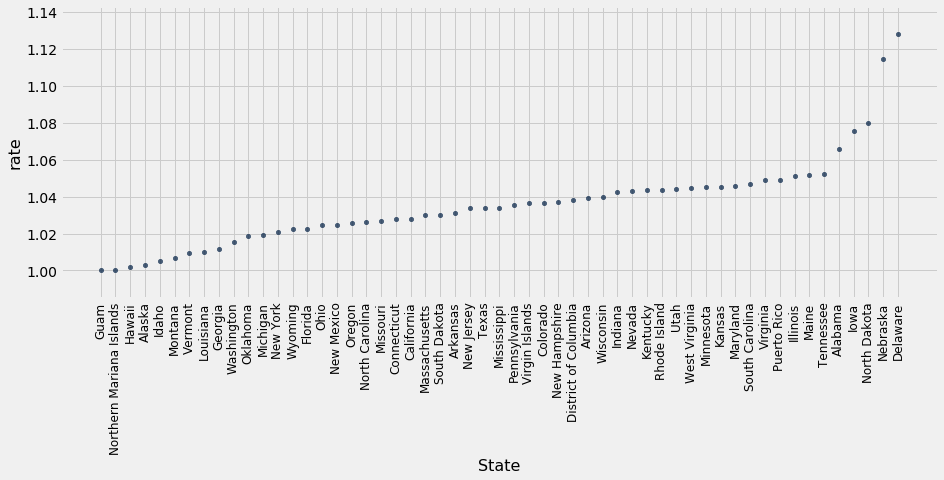

In [51]:
spread(case_sum, 'rate')

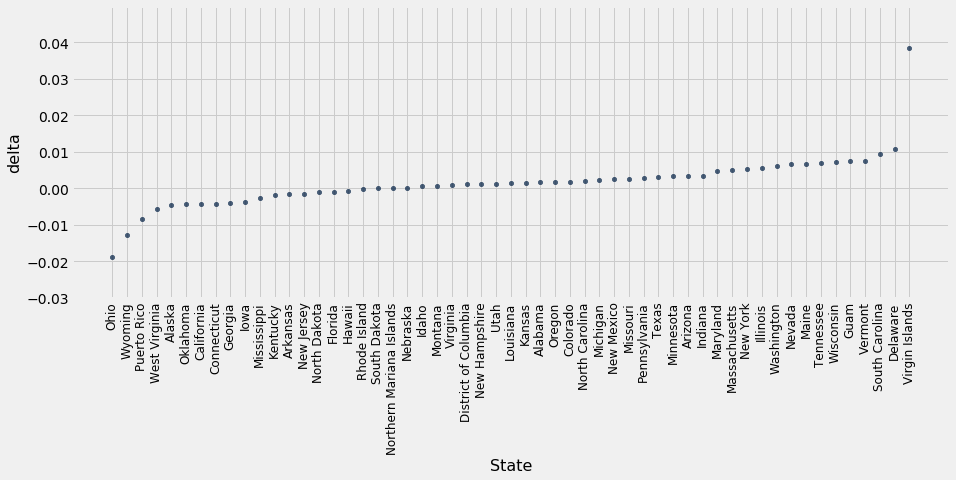

In [52]:
spread(case_sum, 'delta')

In [53]:
def label_point(summary, region, x, y):
    t = summary.where(name, region)
    if np.isfinite(t[x][0]) and np.isfinite(t[y][0]) :
        plots.text(t[x][0], t[y][0], region)

State,confirmed,new,rate,active,arate,eff arate,delta,err
California,43558,1190,1.02809,21852,0.0544573,0.0957973,-0.00418726,0.00426144
Connecticut,25269,686,1.02791,13759,0.0498583,0.0825564,-0.00416588,0.00706704
Florida,31532,693,1.02247,13038,0.0531523,0.0563988,-0.000867927,0.00352372
Illinois,43903,2126,1.05089,24723,0.0859928,0.063636,0.00545371,0.00234233
Louisiana,26773,261,1.00984,6759,0.0386152,0.0395956,0.001416,0.00145332
Massachusetts,54938,1590,1.0298,32078,0.0495667,0.0603708,0.00505599,0.00748924
Michigan,37778,704,1.01899,14173,0.0496719,0.0491728,0.00233808,0.00434155
New Jersey,109038,3540,1.03356,50887,0.0695659,0.0726541,-0.00155865,0.00171077
New York,288045,5902,1.02092,107019,0.0551491,0.0361863,0.00535268,0.00254435
Pennsylvania,42616,1463,1.03555,20897,0.07001,0.0533295,0.00277988,0.00358025


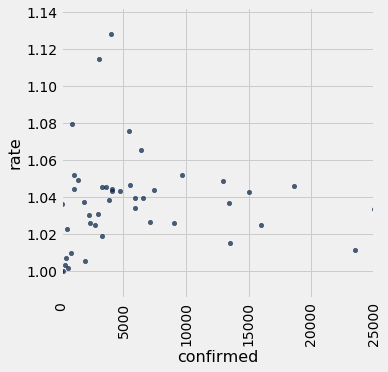

In [54]:
case_sum.scatter('confirmed', 'rate')
_ = plots.xticks(rotation=90)
plots.xlim(0,25000)
case_sum.where(case_sum['confirmed'] > 25000)

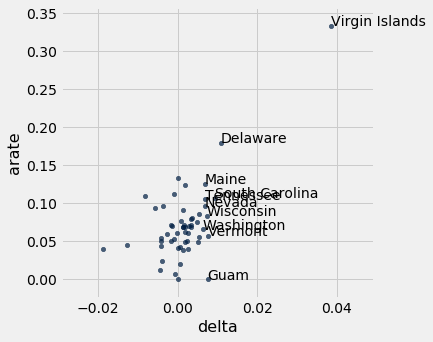

In [55]:
case_sum.scatter('delta', 'arate')
for c in case_sum.where(case_sum['delta'] > 0.006)[name] :
    label_point(case_sum, c, 'delta', 'arate')

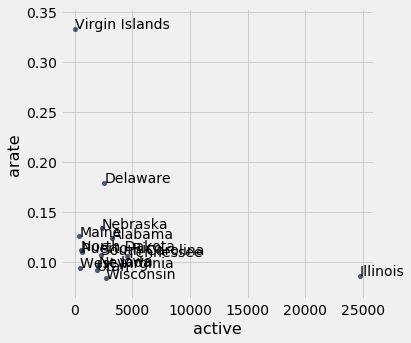

In [56]:
largest_rate = case_sum.sort('arate', descending = True).take[:15]
largest_rate.scatter('active', 'arate')
for c in largest_rate[name] :
    label_point(case_sum, c, 'active', 'arate')

<a id='sectionOneState'></a>
## Cases in one state

These sections of the notebook allow diving into the picture for a particular state.  We start with the basic trends and then look at projects up to a couple weeks out.  Things are changing so rapidly, it is pretty meaningless to talk about numbers farther out than that.  Whereas just looking at the short term puts in stark relief how rapidly we need to move in preparing to care for infected people.

In [57]:
w = widgets.Dropdown(options=list(states), 
                     description='State', value='California')
display(w)

Dropdown(description='State', index=5, options=('Alabama', 'Alaska', 'American Samoa', 'Arizona', 'Arkansas', …

In [58]:
from IPython.core.display import HTML
HTML('''<script> </script> <form action="javascript:IPython.notebook.execute_cells_below()"><input type="submit" id="toggleButton" value="Run All Below"></form>''')

In [59]:
region = w.value
region_case_trend = cases.extract(region).trend()
region

'California'

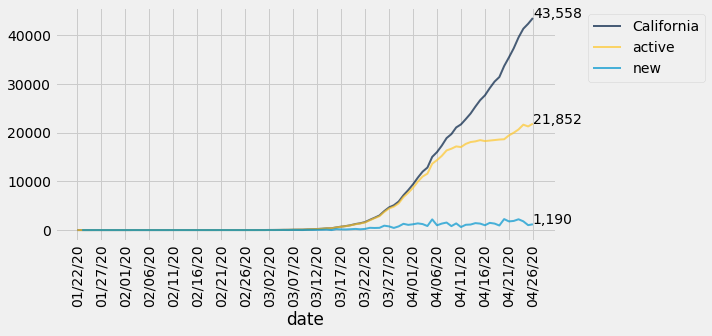

In [60]:
region_case_trend.extract([region, 'active', 'new']).oplot(width=8, xlab=25)
label_val(region_case_trend, last_day, region)
label_val(region_case_trend, last_day, 'active')
label_val(region_case_trend, last_day, 'new')

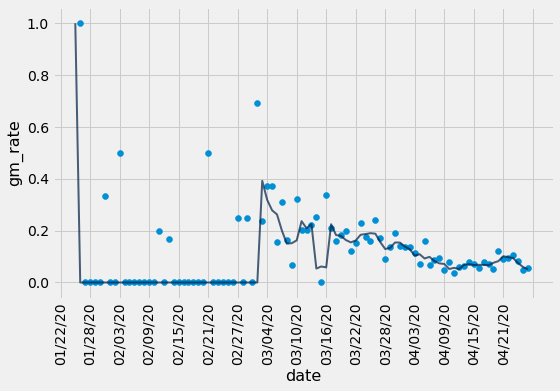

In [61]:
plot_rate_trend(region_case_trend, 'arate')

In [62]:
region_recent = region_case_trend.after("03/15/20")

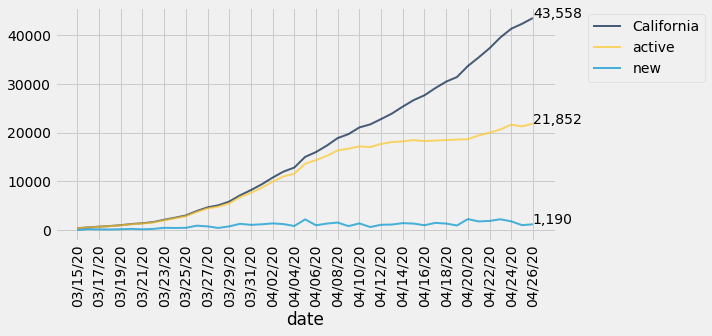

In [63]:
region_recent.extract([region, 'active', 'new']).oplot(width=8, xlab=25)
label_val(region_recent, last_day, region)
label_val(region_recent, last_day, 'active')
label_val(region_recent, last_day, 'new')

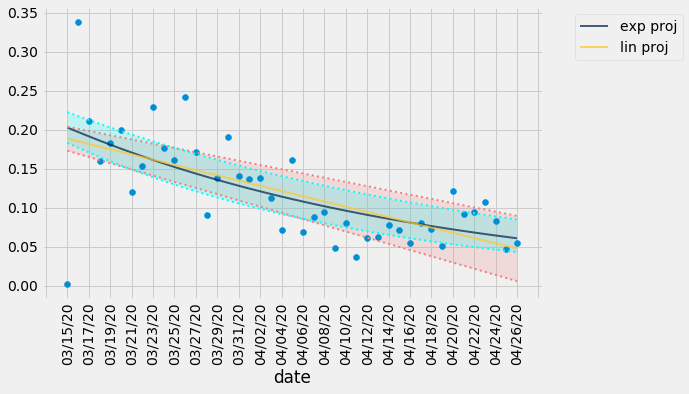

In [64]:
show_model_rate_trend(region_recent, 'arate')

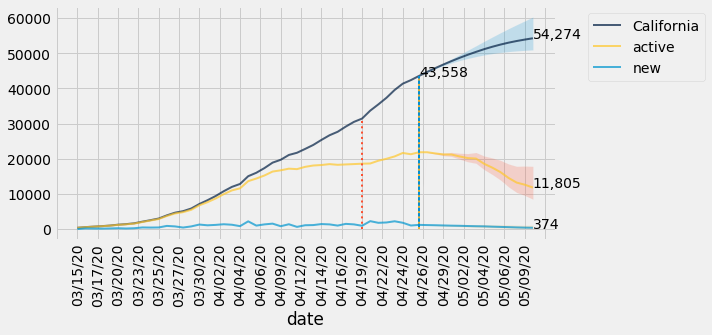

In [65]:
proj_trend(region_recent, region, start=7, end=0, dist=14)

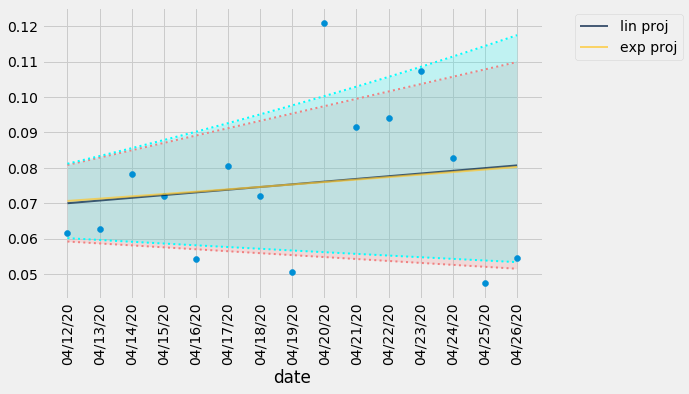

In [66]:
show_model_rate_trend(region_recent.after("04/12/20"), 'arate')

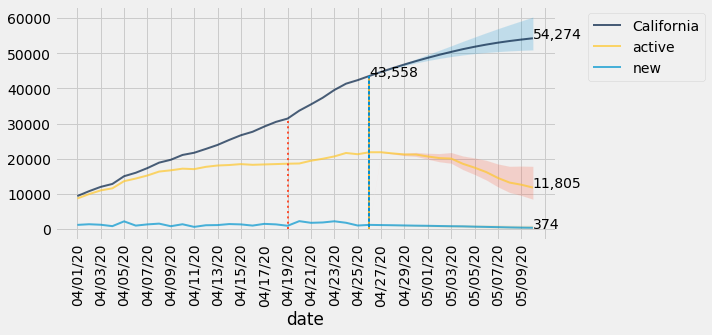

In [67]:
proj_trend(region_recent.after("04/01/20"), region, start=7, end=0, dist=14)

In [68]:
def proj_recent(start=7, end=0, dist=21):
    proj_trend(region_recent, region, start=start, end=end, dist=dist)

In [69]:
_ = interact(proj_recent, start=(5, 21, 1), end=(0, 14, 1), dist=(7, 60, 1))

interactive(children=(IntSlider(value=7, description='start', max=21, min=5), IntSlider(value=0, description='…